In [86]:
import pandas as pd
import configparser
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%aimport helper
%aimport import_dfs

from IPython.core.display import display, HTML
from matplotlib.pyplot import figure
from import_dfs import Datenbank
import helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
'''Datentypen
    staedte: Stadtdaten
    technologiedaten: Technologiedaten
    verbesserungsfaktoren: Verbesserungsfaktoren
    rf_pv_basis: Referenzstrekcen Basis
    rf_pv_pod: Referenzstrecken Pod
    rf_gv_basis: Referenzstrecken Güterverkehr Basis
    rf_gv_pod: Referenzstrecken Güterverkehr Pod
    rf_pv_routes: Strecken Personenverkehr 
    rf_gv_routes: Strecken Güterverkehr
    gemis_data: Daten zur Umrechnung Liter in Emissionen
    spezifischer_verbrauch: Je Klasse der Straßenverkehrsmittel
    bevoelkerungs_und_emissiondaten: BEV und Emissionsdaten
'''

db = Datenbank()

['anpassungen_rf', 'besetzungsgrade', 'bevoelkerungs_und_emissiondaten', 'bevoelkerungsverteilung', 'gemis_data', 'informationen_rad', 'rf_gv_basis', 'rf_gv_pod', 'rf_gv_strecken', 'rf_pv_basis', 'rf_pv_pod', 'rf_pv_strecken', 'spezifischer_verbrauch', 'staedte', 'technologiedaten', 'verkehrsleistung_miv_(omm)']


In [238]:
df = db.rf_pv_basis.drop(columns='bike_sharing').copy()  # init
tech_data = db.technologiedaten.copy()
oev_list = ['bus', 'zug_nahverkehr', 'u_bahn', 'zug_fernverkehr', 'tram']

idx = pd.IndexSlice

unique_modes = tech_data.index.levels[0]
unique_modes_fitted = helper.lower_and_underscores(unique_modes)
unique_modes_dict = dict(zip(unique_modes, unique_modes_fitted))

In [144]:
# Berechnung der Emissionen je Kilometer
rf_pv_basis = df.copy()  # init
df_rad = db.informationen_rad.copy()

per_trip_costs = ["flugzeug", 'bus', 'tram', 'u_bahn']  # In der Literatur nur per Trip angegeben

fitted_index_lvl_0 = helper.lower_and_underscores(tech_data.index.levels[0])  # modes werden angepasst
categorize = tech_data.index.levels[1].to_list()  # Kategorien, in denen die Bewertung vorgenommen wird
categorize.remove('verfuegbarkeit')
categorize.remove('auslastung')

tech_data.index.set_levels(fitted_index_lvl_0, level=0, inplace=True)  # Umbenennen der Kategorien

db.technologiedaten = tech_data

tech_data = pd.DataFrame(tech_data.loc[:, 'klassisch'])  # Ausprobieren für Szenario Klassisch muss angepasst werden

for mode in fitted_index_lvl_0:
        for cat in categorize:
            if mode in rf_pv_basis.columns.to_list() and not (cat == "kosten" and mode in per_trip_costs or cat == 'unfallrisiko'): # Standardfall
                rf_pv_basis.loc[:,f'{mode}_{cat}'] = (rf_pv_basis.loc[:, mode] / 1000) * tech_data.loc[(mode, cat),:].values[0]
            elif mode in rf_pv_basis.columns.to_list() and (cat == "kosten" and mode in per_trip_costs):  # Kosten werden per Trip berechnet
                rf_pv_basis.loc[:,f'{mode}_{cat}'] = rf_pv_basis.apply(lambda x: tech_data.loc[(mode, cat),:].values[0] if x.loc[mode] != 0 else 0, axis=1)
            elif mode in rf_pv_basis.columns.to_list() and cat == 'unfallrisiko':  # Unfallrisiko ist auf 1 Mrd. km bezogen
                rf_pv_basis.loc[:,f'{mode}_{cat}'] = rf_pv_basis.loc[:, mode] * (tech_data.loc[(mode, cat),:].values[0] / 1000000000000)  # Trillion

                
def sum_emissions(df):
    for cat in categorize:
        df.loc[:, f'{cat}'] = df.loc[:,[f'{mode}_{cat}' for mode in unique_modes_fitted]].sum(axis=1)
    return df
            
rf_pv_basis = sum_emissions(rf_pv_basis)

rf_pv_basis.loc[:, 'main_mode'] = rf_pv_basis.loc[:, unique_modes_fitted].idxmax(axis=1)  # find mode with highest length percentage
rf_pv_basis.loc[:, 'num_modes'] = (rf_pv_basis.loc[:,unique_modes_fitted] > 0).sum(axis=1)   # find number of modes in row
rf_pv_basis.loc[:, 'only_mode'] = np.where(rf_pv_basis['num_modes'] == 1, True, False)  # if num modes == 1 -> only_mode = True

rf_pv_basis.loc[:, ['wartezeit', 'fahrtzeit', 'length']] = rf_pv_basis.loc[:, ['wartezeit', 'fahrtzeit', 'length']].round(0).astype(int)
rf_pv_basis.loc[:, 'kosten'] = rf_pv_basis.loc[:, 'kosten'].round(2) 
rf_pv_basis.loc[:, ['energieverbrauch', 'thg', 'nox', 'pm']] = rf_pv_basis.loc[:, ['energieverbrauch', 'thg', 'nox', 'pm']].round(4)

ausgabe = rf_pv_basis.loc[:, ['main_mode', 'only_mode', 'wartezeit', 'fahrtzeit', 'length', 'kosten', 'energieverbrauch', 'thg', 'nox', 'pm', 'unfallrisiko'] ]
rf_pv_basis.head()

,strecken_typ,name_verbindung,transferzeit,wartezeit,fahrtzeit,length,u_bahn,e_bike,zug_nahverkehr,taxi,...,zug_nahverkehr_unfallrisiko,energieverbrauch,kosten,nox,pm,thg,unfallrisiko,main_mode,num_modes,only_mode
index,,,,,,,,,,,,,,,,,,,,,
0.0,UK,1.0,30.0000,0,30,2500,0.0,0.0,0.0,0.0,...,0.0,0.000,0.00,0.0000,0.0000,0.0000,3.550000e-08,zu_fuss,1,True
1.0,UK,1.0,8.0000,0,8,2600,0.0,0.0,0.0,0.0,...,0.0,0.000,0.00,0.0000,0.0000,0.0000,2.418000e-08,fahrrad,1,True
2.0,UK,1.0,16.0000,0,16,3600,0.0,0.0,0.0,0.0,...,0.0,6.080,0.96,1.0880,1.2800,444.8000,1.272000e-08,miv,2,False
3.0,UK,1.0,19.0000,1,18,3790,1620.0,0.0,0.0,0.0,...,0.0,3.128,3.88,0.5648,0.0033,228.9300,9.732000e-09,bus,3,False
4.0,UK,1.0,7.0909,0,7,2600,0.0,2600.0,0.0,0.0,...,0.0,0.065,0.00,0.0078,0.0000,9.5186,2.418000e-08,e_bike,1,True


In [145]:
sns.set(context='paper')
sns.set_palette("Set1", n_colors=8, desat=.5)
plt.rcParams.update({'font.size': 14})

df = rf_pv_basis.copy()

av_speed_name = [f'{mode}_av_speed' for mode in unique_modes_fitted]
times_name = [f'{mode}_time' for mode in unique_modes_fitted]
df = pd.concat([df,pd.DataFrame(columns=av_speed_name+times_name)], sort=False)

def av_speed_calc(row):
    if row['only_mode']:
        row.loc[row['main_mode'] + '_av_speed'] = row.loc[row['main_mode']] / row['fahrtzeit'] * 0.06
    return row

df = df.apply(lambda row: av_speed_calc(row), axis=1)

solo_speeds = (df.loc[:,av_speed_name]
               .mean()
               .dropna()
               .to_dict())

solo_speeds['zu_fuss'] = solo_speeds.pop('zu_fuss_av_speed')
solo_speeds['e_bike'] = solo_speeds.pop('e_bike_av_speed')
solo_speeds['fahrrad'] = solo_speeds.pop('fahrrad_av_speed')

def calc_speeds(solo_speeds, df_start):
    df = df_start.copy()
    for key,val in solo_speeds.items():
        df[f'{key}_time'] = df[key] / val
    return df

df = calc_speeds(solo_speeds, df)
tmp = df.reindex(columns= av_speed_name + ['only_mode', 'strecken_typ'])
tmp = tmp.loc[ tmp.loc[:, 'only_mode'] == True ].dropna(axis=1, how='all').drop(columns='only_mode')
grouped = tmp.groupby('strecken_typ')

#display(HTML(grouped.describe().T.to_html()))
#
#with open('../tables/speeds.tex', 'w') as tf:
#     tf.write(grouped.describe().T.to_latex())
#
#grouped.boxplot()
#
#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(10, 5)
#fig.savefig('../plots/speeds.png', dpi=100)

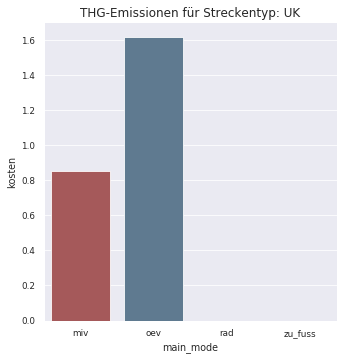

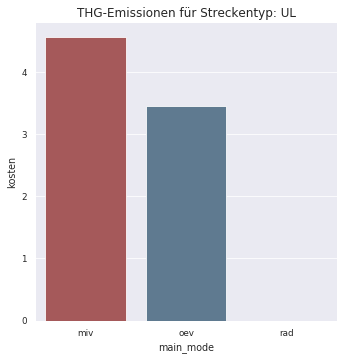

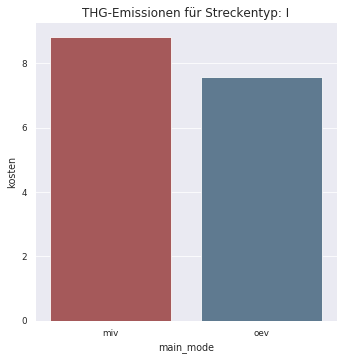

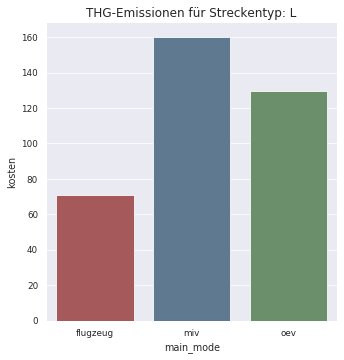

In [299]:
df = rf_pv_basis.copy()

# Zusammenfassen von Oev
df.loc[:, 'oev'] = df.reindex(oev_list, axis='columns').sum(axis=1)
zipped = dict(zip(oev_list, ['oev'] * 5))
df.loc[:, 'main_mode'] = df.apply(lambda row: zipped[row['main_mode']] if row['main_mode'] in oev_list else row['main_mode'], axis=1)
# Zusammenfassen der Fahrräder
df = helper.add_ratios_to_bike(df_rad, df, year = 2017)
df = helper.sum_ratios_bike(df, categorize)
# Zusammenfassen auf Ausgabestrecken
df = helper.ratio_cities(df, db.rf_pv_strecken, db, 'Klassisch').reset_index()
grouped = df.groupby('strecken_typ')

for n in ['UK', 'UL', 'I', 'L']:
    grp = grouped.get_group(n)
    sns.catplot(x="main_mode",y="kosten", kind="bar", data=grp)
    plt.title(f'THG-Emissionen für Streckentyp: {n}', size=12)
    
plt.show()
